# Etudes d'instabilités MagnétoHydroDynamiques

In [1]:
import numpy,scipy,scipy.linalg,time
import matplotlib.pyplot as pyplot
from matplotlib import rcParams, cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

## Instabilités Hydrodynamiques dans un écoulement de type Poiseuille

### Equations et Conditions aux bords

Nous étudions ici un fluide incompressible et visqueux qui s'écoule dans un tube imperméable en deux dimensions selon un profil de vitesse de  Poiseuille, ayant la forme suivante:

$$ U(y) = 1-y^2 $$

Les perturbations $\tilde{v}(x,y,t)$ sur la vitesse se décomposent comme suit:

$$ \tilde{v}(x,y,t) = \frac 12 \left[ v(y)\, e^{i\alpha(x-ct)} + v(y)^{*}\, e^{-i\alpha^{*}(x-c^{*}t)} \right] $$

Comme nous étudions les instabilités temporelles nous avons que $\alpha \in \mathbb R$.

La fonction $v(y)$ de ces perturbations doivent obéir à l'équation d'Orr-Sommerfeld:

$$ \underbrace{\left[ U(D^2-\alpha^2) - U'' - \frac{1}{i\alpha \, Re}(D^2-\alpha^2)^2 \right]}_A v = c \underbrace{(D^2-\alpha^2)}_B v $$

Ce qui défini le problème aux valeurs propres généralisé:

$$ (A-cB)v = 0 $$

Le tube étant imperméable, il est évident que la vitesse selon l'axe y (et en particuler la perturbation $\tilde v(x,y)$) du fluide doit s'annuler aux bords du tube. De plus, étant donné que notre fluide est visqueux, il semble naturel que sa vitesse selon l'axe x s'anulle également près des bords, car les molécules à l'arrêt constituant le tube exercent une force sur le fluide poussant à le freiner. Ce ralentissement se transmet alors au reste du fluide par viscosité. Voir https://en.wikipedia.org/wiki/No-slip_condition. Comme la vitesse $\tilde u(x,y)$ s'anulle au bord pour tout x, alors sa dérivée par rapport à x doit être nulle aussi, ce qui entraîne l'annulation de la dérivée en y de $\tilde v(x,y)$ aux bords, étant donné que le fluide est incompressible:

$$ \tilde{u}_x + \tilde{v}_y = 0 \qquad \text{incompressibilité}$$

$$ \tilde u(x,y) = 0 \ \forall x \Rightarrow \tilde{u}_x(x,y) = 0 \ \forall x \iff \tilde{v}_y(x,y) = 0 \ \forall x \qquad y=0,L$$

Il suit de la condition $\tilde v(x,y) = 0 \ \forall x$ que les vitesses complexes $v(y)$ doivent s'annuler également. En effet:

$$ 0 = \tilde v(x,y) = \frac 12 \left[ v(y)\, e^{i\alpha(x-ct)} + v(y)^{*}\, e^{-i\alpha^{*}(x-c^{*}t)} \right] $$
$$ 0 = v(y)\, e^{i\alpha(x-ct)} + v(y)^{*}\, e^{-i\alpha(x-c^{*}t)} \qquad \alpha \in \mathbb R$$
$$ v(y)^{*} = -v(y)\, e^{i\alpha[(x-ct)+(x-c^{*}t)]} $$

Cette relation étant valable pour $x$ quelconque, il s'en suit que $v(y) = 0$. Le même raisonnement se tient pour montrer que $\tilde v(x,y) = 0 \ \forall x \Rightarrow v'(y) = 0$.

Nous prendrons donc les conditions aux bords suivantes:
    $$\ v(y) = 0 \ \text{en}\  y=0,L \quad\leftrightarrow\quad \text{imperméabilité} \quad\ $$ 
    $$v'(y) = 0 \ \text{en}\  y=0,L \quad\leftrightarrow\quad \text{"no slip condition"}$$

### Discrétisation et implémentations des conditions aux bords

Nous prendrons les discrétisation centrées d'ordre 2 suivantes pour $D^2$ et $D^4$:

$$ (D^2v)_i = \frac{v_{i+1} -2 v_i + v_{i-1}}{(\Delta y)^2} + \mathcal O((\Delta y)^2)$$

$$ (D^4v)_i = \frac{v_{i+2} -4v_{i+1} +6v_i - 4v_{i-1} + v_{i-2}}{(\Delta y)^4} + \mathcal O((\Delta y)^2)$$

Ce qui nous donne les discrétisations pour $Av$ et $Bv$:

$$ (Av)_i = U(y) \left((D^2v)_i - \alpha^2 v_i\right) - U''(y) v_i - \frac{1}{i\alpha\,Re} \left((D^4v)_i -2\alpha^2(D^2v)_i + \alpha^4 v_i\right) $$

$$ (Av)_i = U(y) \left(\frac{v_{i+1} -2 v_i + v_{i-1}}{(\Delta y)^2} - \alpha^2 v_i\right) - U''(y) v_i - \frac{1}{i\alpha\,Re} \left(\frac{v_{i+2} -4v_{i+1} +6v_i - 4v_{i-1} + v_{i-2}}{(\Delta y)^4} -2\alpha^2\frac{v_{i+1} -2 v_i + v_{i-1}}{(\Delta y)^2} + \alpha^4 v_i\right) $$

$$ (Bv)_i = (D^2v)_i - \alpha^2 v_i $$

$$ (Bv)_i = \frac{v_{i+1} -2 v_i + v_{i-1}}{(\Delta y)^2} - \alpha^2 v_i $$

Nous implémentons les opérateurs discrétisés dans des matrices "sparse" qui agirons sur le vecteur colonne $v$.

Remarquons qu'une implémentation directe de ces opérateurs pose problème: que faire des indices extérieurs à la grille (-2, -1, N, N+1) ? Cependant, cela serait ignorer la présence de conditions aux bords, et ce problème est résolu en ajoutant ces dernières. En effet, celles-ci vont nous permettre de prendre en compte les indices extérieurs en les exprimant à partir des indices intérieurs.

Pour implémenter les conditions aux bords, il faut d'abord les discrétiser avec l'ordre d'erreur qui correspond à celui de nos opérateurs.

La discrétisation de la condition $v(y) = 0 \ y=0,L$ est très simple: $v_0 = v_N = 0$ et satisfait tout les ordres.
Nous n'avons donc pas besoin de prendre en compte ces valeurs dans la recherche des modes propres et considérerons alors les opérateurs $D^2$ et $D^4$ comme des matrices $(N-2)\times(N-2)$ agissant sur $(v_1,...,v_{N-2})$.

La discrétisation de la condition $v'(y) = 0 \ y=0,L$ n'est pas beaucoup plus difficile:

$$ 0 = v'(y) = \frac{v_1 - v_{-1}}{2 \Delta y} + \mathcal O((\Delta y)^2) $$ 

Il en découle que $v_1 = v_{-1}$, nous implémentons donc cette condition en remplaçant toute référence à $v_{-1}$ dans $D^2$ et $D^4$ par une référence à $v_1$.

Nous traitons les références à $v_{-2}$ de la même façon, en effet, nous pouvons montrer que la relation suivante est correcte également:

$$ 0 = v'(y) = \frac{v_2 - v_{-2}}{4 \Delta y} + \mathcal O((\Delta y)^2) $$

### Ecriture des fonctions de résolution

On commence par définir le profil utilisé, ici: Poiseuille

In [2]:
def U(y):
    return 1-y**2

Nous implémentons les opérateurs discrétisés avec les conditions aux bords.

In [3]:
def buildD2(N,dy):
    """ Construit la matrice de l'opérateur D2 discrétisé au second ordre avec les bonnes conditions au bord
   
    Paramètres:
    ----------
    N   : Nombres de points de dicrétisation de la grille originale (avec bords)
    dy  : espacement entre les points de la grille de discrétisation
   
    Renvoie:
    -------
    D2  : matrice sparse de l'opérateur D2
    """
    
    D2 = (scipy.eye(N-2,N-2,-1) - 2*scipy.eye(N-2,N-2,0) + scipy.eye(N-2,N-2,1))
    
    return D2/dy**2

In [4]:
def buildD4(N,dy):
    """ Construit la matrice de l'opérateur D4 discrétisé au second ordre avec les bonnes conditions au bord
   
    Paramètres:
    ----------
    N   : Nombres de points de dicrétisation de la grille originale (avec bords)
    dy  : espacement entre les points de la grille de discrétisation
   
    Renvoie:
    -------
    D4  : matrice sparse de l'opérateur D4
    """
    
    D4 = (scipy.eye(N-2,N-2,-2) - 4*scipy.eye(N-2,N-2,-1) + 6*scipy.eye(N-2,N-2,0) - 4*scipy.eye(N-2,N-2,1) + \
          scipy.eye(N-2,N-2,2))
        
    D4[0,0] = 7
    D4[-1,-1] = 7
    
    return D4/dy**4

Vérifions l'implémentation des opérateurs $D^2$ et $D^4$ dans le cas $N=7$ et un espacement $dy=1$ pour avoir les coefficients:

In [5]:
N = 7
D2 = buildD2(N,1)
D4 = buildD4(N,1)

print(D2)
print(D4)

[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]
[[ 7. -4.  1.  0.  0.]
 [-4.  6. -4.  1.  0.]
 [ 1. -4.  6. -4.  1.]
 [ 0.  1. -4.  6. -4.]
 [ 0.  0.  1. -4.  7.]]


In [6]:
def buildAB(Re, alpha, N):
    """ Construit les matrices A et B de l'équation d'Orr-Sommerfeld discrétisée Av = cBv
   
    Paramètres:
    ----------
    Re      : Nombre de Reynolds 
    alpha   : Nombre d'onde de la perturbation
    N       : Nombres de points de dicrétisation de la grille originale (avec bords)
   
    Renvoie:
    -------
    A   
    B   
    """
    dy = 2.0/(N-1)
    y = scipy.linspace(-1,1,N)
    U0 = U(y[1:-1]) * scipy.eye(N-2,N-2)
    U2 = -2 * scipy.eye(N-2,N-2)
    
    Malpha  = alpha    * scipy.eye(N-2,N-2)
    Malpha2 = alpha**2 * scipy.eye(N-2,N-2)
    Malpha4 = alpha**4 * scipy.eye(N-2,N-2)
    
    D2 = buildD2(N,dy)
    D4 = buildD4(N,dy)
    
    A = numpy.dot(U0,(D2-Malpha2)) - U2 - 1/(1j*alpha*Re) * \
        ( D4 - 2* numpy.dot(D2,Malpha2) + Malpha4 )
    B = D2 - Malpha2
    
    return [A,B]

Nous définissons maintenant la fonction qui résouds le problème pour les paramètres $(Re, \alpha)$ voulus.

### Recherche des modes propres: pour un couple ($Re$, $\alpha$)

In [13]:
Re = 10000
alpha = 1
N = 200 # points de la grille avec bords

start = time.time()

[A,B] = buildAB(Re, alpha, N)
stop = time.time()
print(stop-start)

[c,vecp] = scipy.linalg.eig(A,B)
stop = time.time()
print(stop-start)

0.006886720657348633
0.13428854942321777


Les valeurs numériques des valeurs propres instables ou près de l'instabilité sont les suivantes:

In [14]:
print("Valeurs propres:")
print(c[numpy.where(numpy.imag(c)>-0.1)])
print("Indices correspondants:")
print(numpy.where(numpy.imag(c)>-0.1))

Valeurs propres:
[ 0.23698809+0.00363921j  0.27647953-0.05153308j  0.96468704-0.03516839j
  0.96469868-0.03518738j  0.93654776-0.06320595j  0.93658313-0.06325488j
  0.90848995-0.09123325j  0.90856334-0.09132064j]
Indices correspondants:
(array([ 0,  1,  5,  6, 10, 11, 14, 15]),)


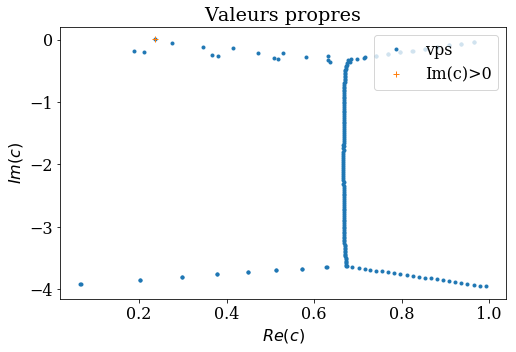

In [15]:
y = scipy.linspace(-1,1,N)

pyplot.figure(figsize=(8,5));
pyplot.plot(numpy.real(c),numpy.imag(c), '.', label='vps');
indices = numpy.where(numpy.imag(c)>0)
pyplot.plot(numpy.real(c[indices]),numpy.imag(c[indices]), '+', label="Im(c)>0");
pyplot.title('Valeurs propres');
pyplot.xlabel('$Re(c)$');
pyplot.ylabel('$Im(c)$');
pyplot.legend(loc=1);
pyplot.show()

Remarquons qu'un très grand nombre de modes propres a été trouvé. Tous les modes calculés ne sont pas valides physiquement et il faut faire le tri parmi les valeurs propres trouvées. Nous pouvons identifier les valeurs non physiques en affinant la discrétisation. En effet, celles-ci dépendent de la discrétisation effectuée et se retrouvent donc plus au même endroit pour un nombre de points différents. Nous reproduisons ci-dessous le calcul pour $N=400$ et observons que beaucoup de valeurs propres se sont déplacées. $<$ identifier les régions $>$

In [16]:
Re = 10000
alpha = 1
N = 400 # on prend plus de points

start = time.time()

[A,B] = buildAB(Re, alpha, N)
stop = time.time()
print(stop-start)

[c,vecp] = scipy.linalg.eig(A,B)
stop = time.time()
print(stop-start)

0.023500442504882812
0.821932315826416


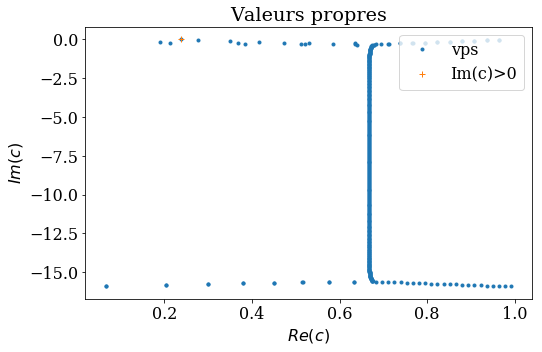

In [17]:
y = scipy.linspace(-1,1,N)

pyplot.figure(figsize=(8,5));
pyplot.plot(numpy.real(c),numpy.imag(c), '.', label='vps');
indices = numpy.where(numpy.imag(c)>0)
pyplot.plot(numpy.real(c[indices]),numpy.imag(c[indices]), '+', label="Im(c)>0");
pyplot.title('Valeurs propres');
pyplot.xlabel('$Re(c)$');
pyplot.ylabel('$Im(c)$');
pyplot.legend(loc=1);
pyplot.show()

Un affichage limité à la région du plan qui contient les valeurs propres physiques est plus adapté:

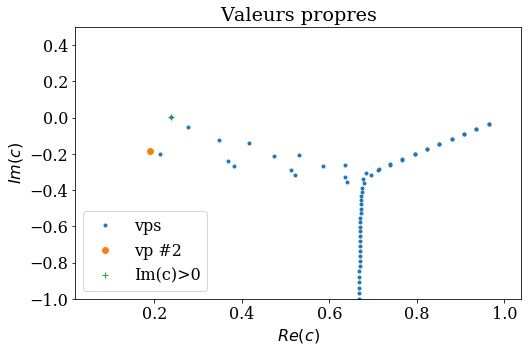

In [18]:
m = 2 # indice de la valeur propre à afficher

pyplot.figure(figsize=(8,5));
pyplot.plot(numpy.real(c),numpy.imag(c), '.', label='vps');
pyplot.plot(numpy.real(c[m]),numpy.imag(c[m]), 'o', label="vp #{:d}".format(m));
indices = numpy.where(numpy.imag(c)>0)
pyplot.plot(numpy.real(c[indices]),numpy.imag(c[indices]), '+', label="Im(c)>0");
pyplot.title('Valeurs propres');
pyplot.xlabel('$Re(c)$');
pyplot.ylabel('$Im(c)$');
pyplot.ylim([-1,0.5]) # on se limite à la région du plan qui contient les valeurs propres physiques
pyplot.legend(loc=3);
pyplot.show()

Nous pouvons afficher le vecteur propre associé à la valeur propre marquée en orange. Notons que celle-ci respecte les conditions imposées aux bords.

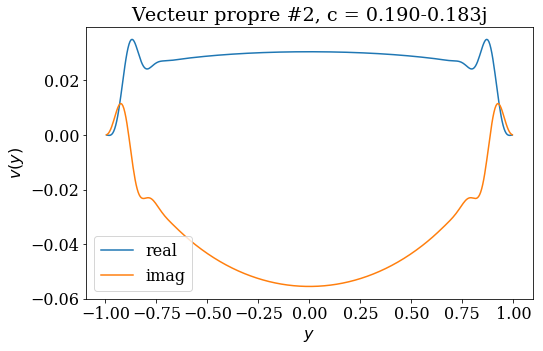

In [19]:
m = 2 # indice de la valeur propre à afficher

pyplot.figure(figsize=(8,5));
pyplot.plot(y[1:-1],numpy.real(vecp[:,m]), '-', label='real');
pyplot.plot(y[1:-1],numpy.imag(vecp[:,m]), '-', label='imag');
pyplot.title("Vecteur propre #{:d}, c = {:.3f}".format(m,c[m]));
pyplot.xlabel('$y$');
pyplot.ylabel('$v(y)$');
pyplot.legend(loc=3);
pyplot.show()

### Recherche des modes propres: comparaison avec une valeur de référence et convergence

In [20]:
Ns = 250*numpy.array([1,1.5,1.5**2,1.5**3,1.5**4,1.5**5,1.5**6])
print(Ns)

[  250.        375.        562.5       843.75     1265.625    1898.4375
  2847.65625]


In [21]:
Ns = numpy.array([250,375,563,844,1266,1898,2848])
values = numpy.zeros((8,len(Ns))).astype(complex)

Re = 10000
alpha = 1

for i in range(len(Ns)):
    
    start = time.time()
    
    [A,B] = buildAB(Re, alpha, Ns[i])
    [c,vecp] = scipy.linalg.eig(A,B)

    print("Eigenvalues for N={:d} are: ".format(Ns[i]))
    print(c[numpy.where((numpy.imag(c)>-0.1) & (numpy.imag(c)<0.5))])
    values[:,i] = c[numpy.where((numpy.imag(c)>-0.1) & (numpy.imag(c)<0.5))][:8]
    
    stop = time.time()
    print("Execution time for N={:d} is {:.3f} seconds".format(Ns[i],stop-start))

print("Specific eigenvalue for each N: ")
print(values)

Eigenvalues for N=250 are: 
[ 0.23718380+0.00367973j  0.27674151-0.0512998j   0.96466674-0.03516797j
  0.96467837-0.03518708j  0.93646409-0.06320423j  0.93649944-0.06325357j
  0.90830643-0.0912291j   0.90837982-0.09131747j]
Execution time for N=250 is 0.223 seconds
Eigenvalues for N=375 are: 
[ 0.23737518+0.00371492j  0.27699929-0.05107475j  0.96464678-0.03516758j
  0.96465840-0.0351868j   0.93638188-0.06320266j  0.93641718-0.06325241j
  0.90812623-0.0912254j   0.90819957-0.09131475j]
Execution time for N=375 is 0.600 seconds
Eigenvalues for N=563 are: 
[ 0.23745961+0.00372907j  0.27711356-0.05097634j  0.96463794-0.03516741j
  0.96464955-0.03518668j  0.93634546-0.063202j    0.93638074-0.06325193j
  0.90804643-0.09122389j  0.90811974-0.09131367j]
Execution time for N=563 is 2.576 seconds
Eigenvalues for N=844 are: 
[ 0.23749679+0.00373503j  0.27716400-0.05093315j  0.96463404-0.03516734j
  0.96464564-0.03518662j  0.93632939-0.06320172j  0.93636465-0.06325173j
  0.90801121-0.09122324j  0.

KeyboardInterrupt: 

Nous affichons dans le tableau qui suit pour quelques valeurs propres trouvées dans le livre de référence: "Theory and computation of hydrodynamic stability" par W.O.Criminale, T.L.Jackson et R.D.Joslin, page 80. Le couple $(Re,\alpha)$ pour ces valeurs propres est le même que celui choisi ici: (1,10000).

|  Re(c)  |  Im(c)   |
|---------|----------|
| 0.23753 |  0.00374 |
| 0.96464 | -0.03519 |
| 0.93635 | -0.06325 |
| 0.90806 | -0.09131 |


En regardant les valeurs les plus précises calculées dans la cellule précédante, nous constatons que les résultats obtenus convergent effectivement vers ce qui est attendu pour le même problème. Nous n'avons pas affiché de valeurs de référence pour chacune des valeurs propres calculées car seulement les modes symétriques sont mentionnés dans le livre de référence.

In [48]:
erreurs = numpy.zeros((8,len(Ns)))
for i in range(8):
    erreurs[i,:] = abs(numpy.imag(values[i,:]-values[i,-1]))
print(erreurs)

ordres = numpy.zeros((8,len(Ns)-2))
for i in range(8):
    ordres[i,:] = (numpy.log10(erreurs[i,1:-1])-numpy.log10(erreurs[i,:-2]))/(numpy.log10(Ns[1:-1])-numpy.log10(Ns[:-2]))
print(ordres)

[[  1.27063588e-03   5.12671372e-04   1.99333167e-04   6.80389107e-05
    1.24076300e-05   7.26923939e-06   0.00000000e+00]
 [  1.47536131e-03   5.58801282e-04   1.97050658e-04   6.03177621e-05
    1.29018813e-05   2.14040864e-07   0.00000000e+00]
 [  3.45688176e-07   1.91627299e-07   5.47261233e-08   4.53656387e-08
    1.15713812e-07   1.59326057e-07   0.00000000e+00]
 [  4.84071264e-07   2.02607147e-07   8.34732800e-08   3.20075092e-08
    9.34812847e-09   3.25637142e-10   0.00000000e+00]
 [  6.40413683e-07   7.59011687e-07   6.12108171e-07   4.40475762e-07
    2.96867770e-07   1.85619105e-07   0.00000000e+00]
 [  1.99830880e-06   8.33388616e-07   3.55872109e-07   1.52453165e-07
    6.39320328e-08   2.21551511e-08   0.00000000e+00]
 [  3.89241921e-07   6.32779162e-07   6.79679067e-07   5.00771010e-07
    2.98339953e-07   1.33278431e-07   0.00000000e+00]
 [  4.56179108e-06   1.83903134e-06   7.53707685e-07   2.98305771e-07
    9.74637849e-08   1.18945137e-08   0.00000000e+00]]
[[ -2.2

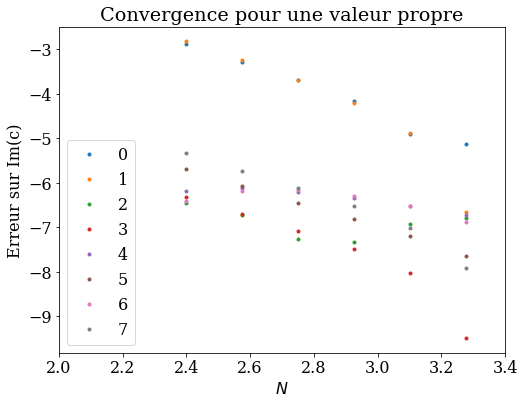

In [57]:
pyplot.figure(figsize=(8,6));
for i in range(8):
    pyplot.plot(numpy.log10(Ns[:-1]), numpy.log10(erreurs[i,:-1]), '.', label="{:d}".format(i));
pyplot.title('Convergence pour une valeur propre');
pyplot.xlabel('$N$')
pyplot.ylabel('Erreur sur Im(c)')
pyplot.xlim([2,3.4])
pyplot.grid(1,which='minor')
pyplot.legend(loc=3)
pyplot.show()

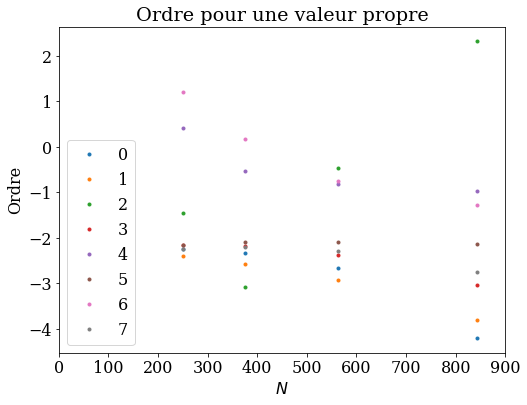

In [58]:
pyplot.figure(figsize=(8,6));
for i in range(8):
    pyplot.plot(Ns[:-3], ordres[i,:-1], '.', label="{:d}".format(i));
pyplot.title('Ordre pour une valeur propre');
pyplot.xlabel('$N$')
pyplot.ylabel('Ordre')
pyplot.xlim([0,900])
pyplot.grid(1,which='minor')
pyplot.legend(loc=3)
pyplot.show()

### Discrétisation de type *forward* et *backward* pour les dérivées au bord

Redéfinissons les opérateurs de dérivée en implémentant la condition $v'(y)=0$ avec des discrétisations de type forward et backward. L'idée est ici de ne pas faire référence à $v_{-2}$ afin de ne pas utiliser la discrétisation centrée d'ordre 2 faite avec deux points de discrétisation d'écart. En effet, la discrétisation utilisée,

$$ 0 = v'(y) = \frac{v_2 - v_{-2}}{4 \Delta y} + \mathcal O((\Delta y)^2) $$

pourrait converger beaucoup plus lentement, bien que du bon ordre, car le facteur d'erreur serait plus grand.

La condition au bord $y=-1$ discrétisée dans le cas *forward* s'écrit:

$$ 0 = v'(y) = \frac{-\frac 32 v_0 + 2 v_1 -\frac 12 v_2}{\Delta y} + \mathcal O((\Delta y)^2) 
    \iff v_1 = \frac 14 v_2 + \mathcal O((\Delta y)^3)   \qquad \text{sachant que}\qquad v_0 = 0$$

et dans le cas *backwards* en $y=1$:

$$ 0 = v'(y) = \frac{\frac 32 v_{N-3} - 2 v_{N-2} +\frac 12 v_{N-1}}{\Delta y} + \mathcal O((\Delta y)^2) 
    \iff v_{N-2} = \frac 14 v_{N-3} + \mathcal O((\Delta y)^3)  \qquad \text{sachant que}\qquad v_{N-1} = 0$$

Nous allons donc réduire le problème aux valeurs propres de deux dimensions en ne calculant plus l'évolution pour $v_1$ ni $v_{N-2}$, que nous pouvons toutes deux remplacer par les expressions ci-dessus.

In [31]:
def buildD2_forward(N,dy):
    """ Construit la matrice de l'opérateur D2 discrétisé de type forward (et backward) au second ordre 
    avec les bonnes conditions au bord
   
    Paramètres:
    ----------
    N   : Nombres de points de dicrétisation de la grille originale (avec bords)
    dy  : espacement entre les points de la grille de discrétisation
   
    Renvoie:
    -------
    D2  : matrice sparse de l'opérateur D2
    """
    
    D2 = (scipy.eye(N-4,N-4,-1) - 2*scipy.eye(N-4,N-4,0) + scipy.eye(N-4,N-4,1))
    
    D2[0,0] = -7/4
    D2[-1,-1] = -7/4
    
    return D2/dy**2

In [33]:
def buildD4_forward(N,dy):
    """ Construit la matrice de l'opérateur D4 discrétisé de type forward (et backward) au second ordre 
    avec les bonnes conditions au bord
   
    Paramètres:
    ----------
    N   : Nombres de points de dicrétisation de la grille originale (avec bords)
    dy  : espacement entre les points de la grille de discrétisation
   
    Renvoie:
    -------
    D4  : matrice sparse de l'opérateur D4
    """
    
    D4 = (scipy.eye(N-4,N-4,-2) - 4*scipy.eye(N-4,N-4,-1) + 6*scipy.eye(N-4,N-4,0) - 4*scipy.eye(N-4,N-4,1) + \
          scipy.eye(N-4,N-4,2))
        
    D4[0,0] = 5
    D4[1,0] = -15/4
    D4[-1,-1] = 5
    D4[-2,-1] = -15/4
    
    return D4/dy**4

Vérifions l'implémentation des opérateurs $D^2$ et $D^4$ dans le cas $N=9$ et un espacement $dy=1$ pour avoir les coefficients:

In [34]:
N = 9
D2 = buildD2_forward(N,1)
D4 = buildD4_forward(N,1)

print(D2)
print(D4)

[[-1.75  1.    0.    0.    0.  ]
 [ 1.   -2.    1.    0.    0.  ]
 [ 0.    1.   -2.    1.    0.  ]
 [ 0.    0.    1.   -2.    1.  ]
 [ 0.    0.    0.    1.   -1.75]]
[[ 5.   -4.    1.    0.    0.  ]
 [-3.75  6.   -4.    1.    0.  ]
 [ 1.   -4.    6.   -4.    1.  ]
 [ 0.    1.   -4.    6.   -3.75]
 [ 0.    0.    1.   -4.    5.  ]]


In [35]:
def buildAB_forward(Re, alpha, N):
    """ Construit les matrices A et B de l'équation d'Orr-Sommerfeld discrétisée Av = cBv avec une implémentation 
    forward et backward des conditions aux bords
   
    Paramètres:
    ----------
    Re      : Nombre de Reynolds 
    alpha   : Nombre d'onde de la perturbation
    N       : Nombres de points de dicrétisation de la grille originale (avec bords)
   
    Renvoie:
    -------
    A   
    B   
    """
    dy = 2.0/(N-1)
    y = scipy.linspace(-1,1,N)
    U0 = U(y[2:-2]) * scipy.eye(N-4,N-4)
    U2 = -2 * scipy.eye(N-4,N-4)
    
    Malpha  = alpha    * scipy.eye(N-4,N-4)
    Malpha2 = alpha**2 * scipy.eye(N-4,N-4)
    Malpha4 = alpha**4 * scipy.eye(N-4,N-4)
    
    D2 = buildD2_forward(N,dy)
    D4 = buildD4_forward(N,dy)
    
    A = numpy.dot(U0,(D2-Malpha2)) - U2 - 1/(1j*alpha*Re) * \
        ( D4 - 2* numpy.dot(D2,Malpha2) + Malpha4 )
    B = D2 - Malpha2
    
    return [A,B]

In [36]:
N = 9
Re = 10000
alpha = 1
[A,B] = buildAB_forward(Re, alpha, N)

print(-1j*A)
print(B)

[[ 0.1337+19.75j   -0.1056-12.j      0.0256 -0.j      0.0000 -0.j
   0.0000 -0.j    ]
 [-0.0992-15.j      0.1601+28.9375j -0.1056-15.j      0.0256 -0.j
   0.0000 -0.j    ]
 [ 0.0256 -0.j     -0.1056-16.j      0.1601+31.j     -0.1056-16.j
   0.0256 -0.j    ]
 [ 0.0000 -0.j      0.0256 -0.j     -0.1056-15.j      0.1601+28.9375j
  -0.0992-15.j    ]
 [ 0.0000 -0.j      0.0000 -0.j      0.0256 -0.j     -0.1056-12.j
   0.1337+19.75j  ]]
[[-29.  16.   0.   0.   0.]
 [ 16. -33.  16.   0.   0.]
 [  0.  16. -33.  16.   0.]
 [  0.   0.  16. -33.  16.]
 [  0.   0.   0.  16. -29.]]


### Convergence du calcul des modes propres pour la discrétisation forward des conditions aux bords

In [38]:
Ns = numpy.array([250,375,563,844,1266,1898,2848])
values = numpy.zeros((8,len(Ns))).astype(complex)

Re = 10000
alpha = 1

for i in range(len(Ns)):
    
    start = time.time()
    
    [A,B] = buildAB_forward(Re, alpha, Ns[i])
    [c,vecp] = scipy.linalg.eig(A,B)

    print("Eigenvalues for N={:d} are: ".format(Ns[i]))
    print(c[numpy.where((numpy.imag(c)>-0.1) & (numpy.imag(c)<0.5))])
    print(c)
    values[:,i] = c[numpy.where((numpy.imag(c)>-0.1) & (numpy.imag(c)<0.5))][:8]
    
    stop = time.time()
    print("Execution time for N={:d} is {:.3f} seconds".format(Ns[i],stop-start))

print("Specific eigenvalue for each N: ")
print(values)

Eigenvalues for N=9 are: 
-0.00177761763091
[ 0.44993096-0.00177762j  0.64588241-0.0032487j   0.75925696-0.00358344j
  0.86472743-0.00393504j  0.93878281-0.00540252j]


ValueError: could not broadcast input array from shape (5) into shape (8)

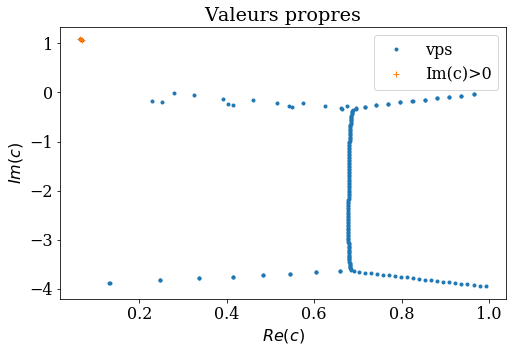

In [11]:
pyplot.figure(figsize=(8,5));
pyplot.plot(numpy.real(c),numpy.imag(c), '.', label='vps');
indices = numpy.where(numpy.imag(c)>0)
pyplot.plot(numpy.real(c[indices]),numpy.imag(c[indices]), '+', label="Im(c)>0");
pyplot.title('Valeurs propres');
pyplot.xlabel('$Re(c)$');
pyplot.ylabel('$Im(c)$');
pyplot.legend(loc=1);
pyplot.show()

In [ ]:
erreurs = numpy.zeros((8,len(Ns)))
for i in range(8):
    erreurs[i,:] = abs(numpy.imag(values[i,:]-values[i,-1]))
print(erreurs)

ordres = numpy.zeros((8,len(Ns)-2))
for i in range(8):
    ordres[i,:] = (numpy.log10(erreurs[i,1:-1])-numpy.log10(erreurs[i,:-2]))/(numpy.log10(Ns[1:-1])-numpy.log10(Ns[:-2]))
print(ordres)

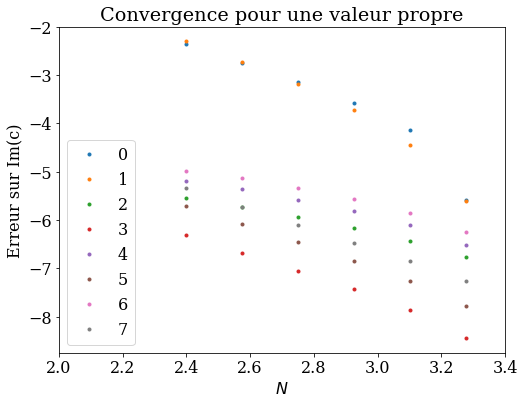

In [45]:
pyplot.figure(figsize=(8,6));
for i in range(8):
    pyplot.plot(numpy.log10(Ns[:-1]), numpy.log10(erreurs[i,:-1]), '.', label="{:d}".format(i));
pyplot.title('Convergence pour une valeur propre');
pyplot.xlabel('$N$')
pyplot.ylabel('Erreur sur Im(c)')
pyplot.xlim([2,3.4])
pyplot.grid(1,which='minor')
pyplot.legend(loc=3)
pyplot.show()

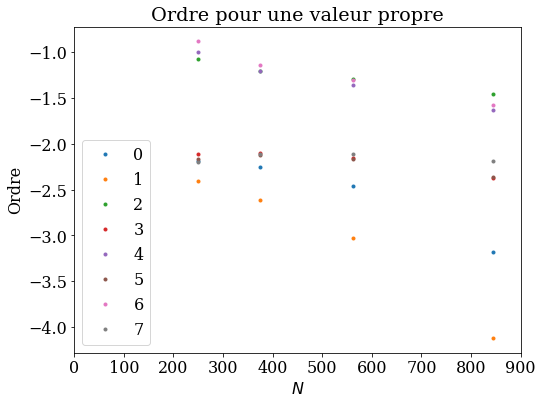

In [46]:
pyplot.figure(figsize=(8,6));
for i in range(8):
    pyplot.plot(Ns[:-3], ordres[i,:-1], '.', label="{:d}".format(i));
pyplot.title('Ordre pour une valeur propre');
pyplot.xlabel('$N$')
pyplot.ylabel('Ordre')
pyplot.xlim([0,900])
pyplot.grid(1,which='minor')
pyplot.legend(loc=3)
pyplot.show()

Remarquons que le convergence semble plus régulière (voir graphique des erreurs) mais pas particulièrement plus rapide.

### Recherche des modes propres: diagramme de stabilité selon ($Re$, $\alpha$)

Dans cette section, nous établissons un diagramme indiquant quelles combinaisons des paramètres $(Re,\alpha)$ sont instables. 

Commençons par calculer les vitesses dans modes propres pour plusieurs couples $(Re,\alpha)$.

In [11]:
alpha = numpy.linspace(0.2,1.2,20)
Re = numpy.linspace(100,50100,20)
N = 200 # points de la grille avec bords

c = numpy.zeros((len(Re),len(alpha),N-2)).astype(complex)
#vecp = numpy.zeros((len(Re),len(alpha),N, N)).astype(complex)

for i in range(len(Re)):
    print("loop {:d} of {:d}".format(i,len(Re)))
    for j in range(len(alpha)):
        [A,B] = buildAB(Re[i], alpha[j], N)
        c[i,j,:] = scipy.linalg.eig(A,B)[0]

loop 0 of 20
loop 1 of 20
loop 2 of 20
loop 3 of 20
loop 4 of 20
loop 5 of 20
loop 6 of 20
loop 7 of 20
loop 8 of 20
loop 9 of 20
loop 10 of 20
loop 11 of 20
loop 12 of 20
loop 13 of 20
loop 14 of 20
loop 15 of 20
loop 16 of 20
loop 17 of 20
loop 18 of 20
loop 19 of 20


Nous devons ensuite déterminer quels couples donnent des modes propres instables. Dans ce but, nous cherchons pour chaque couple $(Re,\alpha)$ s'il possède au moins un mode dont la partie imaginaire $\text{Im}(c)$ de sa vitesse de propagation (stockée dans la variable "$c$") est supérieure à $0$. Nous demandons aussi que $\text{Im}(c)<0.5$ afin de ne pas compter les deux valeurs propres non-physiques situées dans la partie supérieure du plan complexe. Il nous faudra aussi vérifier que cette condition arbitraire n'élimine pas de valeurs propres physiques et est efficace pour éliminer les valeurs propres non physiques.

In [12]:
instabilityMap = numpy.zeros((len(Re),len(alpha)))

for i in range(len(Re)):
    for j in range(len(alpha)):
        cUnstable = c[i,j,numpy.where((numpy.imag(c[i,j,:])>0) & (numpy.imag(c[i,j,:])<0.3))[0]]
        if len(cUnstable)!=0:
            instabilityMap[i,j] = 1


Res0 = numpy.empty((1))
alphas0 = numpy.empty((1))
Res1 = numpy.empty((1))
alphas1 = numpy.empty((1))

for i in range(len(Re)):
    for j in range(len(alpha)):
        if instabilityMap[i,j]==0:
            Res0 = numpy.concatenate((Res0,[Re[i]]), axis=0)
            alphas0 = numpy.concatenate((alphas0,[alpha[j]]), axis=0)
        if instabilityMap[i,j]==1:
            Res1 = numpy.concatenate((Res1,[Re[i]]), axis=0)
            alphas1 = numpy.concatenate((alphas1,[alpha[j]]), axis=0)

Construisons deux listes des valeurs propres de partie imaginaires positives classée selon notre seuil comme physiques et non-physiques.

In [13]:
csUnstablePhysical = numpy.array([])
csUnstableNonPhysical = numpy.array([])

for i in range(len(Re)):
    for j in range(len(alpha)):
        cUnstablePhysical = c[i,j,numpy.where((numpy.imag(c[i,j,:])>0) & (numpy.imag(c[i,j,:])<0.3))[0]]
        cUnstableNonPhysical = c[i,j,numpy.where((numpy.imag(c[i,j,:])>0) & (numpy.imag(c[i,j,:])>=0.3))[0]]
        csUnstablePhysical = numpy.concatenate((csUnstablePhysical,cUnstablePhysical),axis=0)
        csUnstableNonPhysical = numpy.concatenate((csUnstableNonPhysical,cUnstableNonPhysical),axis=0)

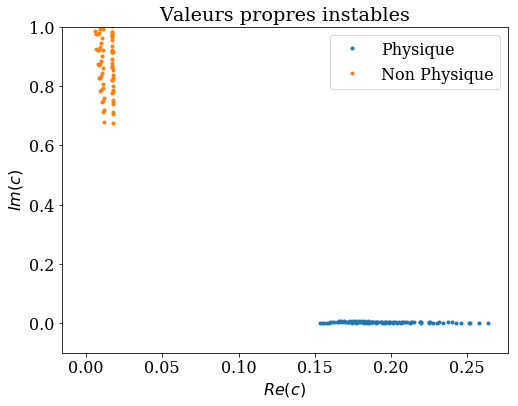

In [14]:
pyplot.figure(figsize=(8,6));
pyplot.plot(numpy.real(csUnstablePhysical), numpy.imag(csUnstablePhysical), '.', label='Physique');
pyplot.plot(numpy.real(csUnstableNonPhysical), numpy.imag(csUnstableNonPhysical), '.', label='Non Physique');
pyplot.title('Valeurs propres instables');
pyplot.xlabel('$Re(c)$')
pyplot.ylabel('$Im(c)$')
pyplot.ylim([-0.1,1])
pyplot.legend(loc=1);
pyplot.show()

Nous remarquons sur le dernier graphique que le choix de seuil à $0.3$ convient bien pour différencier les valeurs propres physiques des non-physiques.

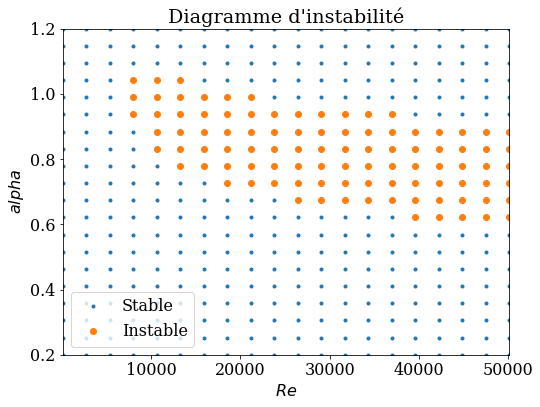

In [15]:
pyplot.figure(figsize=(8,6));
pyplot.plot(Res0, alphas0, '.', label='Stable');
pyplot.plot(Res1, alphas1, 'o', label='Instable');
pyplot.title('Diagramme d\'instabilité');
pyplot.xlabel('$Re$')
pyplot.ylabel('$alpha$')
pyplot.xlim([Re[0], Re[-1]])
pyplot.ylim([alpha[0], alpha[-1]])
pyplot.legend(loc=3);
pyplot.show()

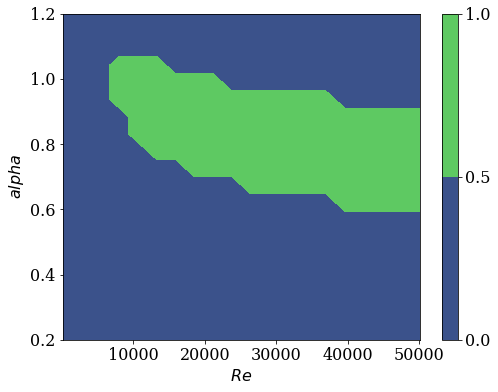

In [16]:
pyplot.figure(figsize=(8,6))
pyplot.contourf(Re,alpha,instabilityMap.T,1,cmap=cm.viridis)
pyplot.xlabel('$Re$')
pyplot.ylabel('$alpha$')
pyplot.colorbar();
pyplot.show()

Encore une fois, les résultats obtenus correspondent à ceux obtenus pour le même problème dans $<$insérer référence criminale$>$
$<$insérer image$>$

### Modes symétriques et antisymétriques

Dans cette section, nous vérifions que les modes instables sont uniquement des modes symétriques, c-à-d pour lesquels $v(y) = v(L-y)$. 

Il ne devrait effectivement pas exister de modes antisymétriques instables. En effet, un tel mode voit sa dérivée seconde de la vitesse s'annuler au centre, i.e. $D^2v = 0$. Par conséquent, l'équation d'Orr-Sommerfeld se réduit à 

$$ -(U-c)\alpha^2 v - U''v = \frac{1}{i Re} \alpha^3 v $$

La condition d'instabilité dans notre choix de signe est que $\text{Im}(c)>0$. Prenons les parties imaginaires des deux membres:

$$ \text{Im}(LHS) = \text{Im}(c)\ \text{Im}(v) $$
$$ \text{Im}(RHS) = \text{Im}(-i)\ \text{Im}(v) $$

Comme $\text{Im}(c)>0$ et $\text{Im}(-i)=-1$ , les deux termes ne peuvent être égaux et l'existance d'un mode antisymétrique instable contredit donc l'équation d'Orr-Sommerfeld.

In [20]:
def checkIfSymmetric(vecp):
    """ Vérifie la parité d'un mode propre
   
    Paramètres:
    ----------
    vecp    : Mode propre
   
    Renvoie "true" si le mode est symétrique et "false" sinon
    """
    
    N = len(vecp)
    diffSym = vecp[int(N/4)]-vecp[-1-int(N/4)] # petit si mode symétrique
    
    return (abs(diffSym) <= abs(vecp[int(N/2)]))

In [24]:
def categoriseModes(c,vecp):
    """ Trie les modes propres selon leur parité
   
    Paramètres:
    ----------
    c       : Vecteur contenant les valeurs propres
    vecp    : Vecteur contenant les modes propres associé
   
    Renvoie:
    --------
    cSym        : Vecteur contenant les valeurs propres symétriques
    cAntiSym    : Vecteur contenant les valeurs propres anti-symétriques
    vecpSym     : Vecteur contenant les vecteur propres symétriques associés
    vecpAntiSym : Vecteur contenant les vecteur propres anti-symétriques associés
    """
    
    N = len(vecp[:,0])
    cSym = numpy.array([])
    cAntisym = numpy.array([])
    vecpSym = numpy.array([])
    vecpAntisym = numpy.array([])
    
    for i in range(len(c)):
        
        if (checkIfSymmetric(vecp[:,i])):
            cSym = numpy.append(cSym, c[i])
            vecpSym = numpy.append(vecpSym, vecp[:,i])
        else:
            cAntisym = numpy.append(cAntisym, c[i])
            vecpAntisym = numpy.append(vecpAntisym, vecp[:,i])
    
    return [cSym,cAntisym,vecpSym, vecpAntisym]

In [22]:
alpha = 1
Re = 10000
N = 200

[A,B] = buildAB(Re, alpha, N)
[c,vecp] = scipy.linalg.eig(A,B)
[cSym,cAntisym,vecpSymn, vecpAntisym] = categoriseModes(c,vecp)

TypeError: buildD2() missing 1 required positional argument: 'dy'

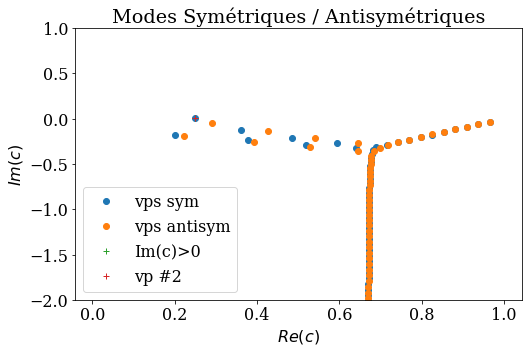

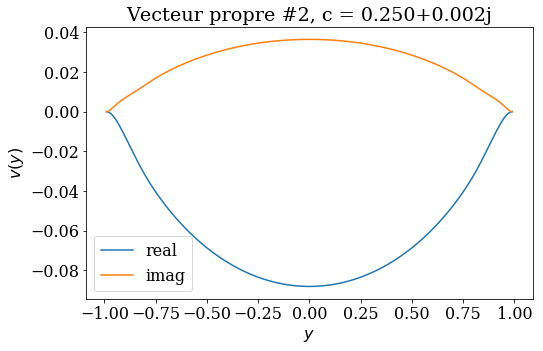

(array([0, 1, 2]),)


In [20]:
y = scipy.linspace(-1,1,N)
m = 2;

pyplot.figure(figsize=(8,5));
pyplot.plot(numpy.real(cSym),numpy.imag(cSym), 'o', label='vps sym');
pyplot.plot(numpy.real(cAntisym),numpy.imag(cAntisym), 'o', label='vps antisym');
indices = numpy.where(numpy.imag(c)>0)
pyplot.plot(numpy.real(c[indices]),numpy.imag(c[indices]), '+', label="Im(c)>0");
pyplot.plot(numpy.real(c[m]),numpy.imag(c[m]), '+', label="vp #{:d}".format(m));
pyplot.title('Modes Symétriques / Antisymétriques');
pyplot.xlabel('$Re(c)$');
pyplot.ylabel('$Im(c)$');
pyplot.ylim([-2,1])
pyplot.legend(loc=3);
pyplot.show()

pyplot.figure(figsize=(8,5));
pyplot.plot(y[1:-1],numpy.real(vecp[:,m]), '-', label='real');
pyplot.plot(y[1:-1],numpy.imag(vecp[:,m]), '-', label='imag');
pyplot.title("Vecteur propre #{:d}, c = {:.3f}".format(m,c[m]));
pyplot.xlabel('$y$');
pyplot.ylabel('$v(y)$');
pyplot.legend(loc=3);
pyplot.show()

print(indices)

En répètant le test sur plusieurs couples (Re,alpha), on vérifie ainsi que ce sont bien les modes symétriques qui engendrent les instabilités

In [21]:
alpha = numpy.linspace(0.2,1.2,20)
Re = numpy.linspace(100,50100,20)
N = 200

c = numpy.zeros((len(Re),len(alpha),N-2)).astype(complex)
vecp = numpy.zeros((len(Re),len(alpha),N,N-2)).astype(complex)

for i in range(len(Re)):
    print("loop {:d} of {:d}".format(i+1,len(Re)))
    for j in range(len(alpha)):
        [A,B] = buildAB(Re[i], alpha[j], N)
        c[i,j,:] = scipy.linalg.eig(A,B)[0]

loop 1 of 20
loop 2 of 20
loop 3 of 20
loop 4 of 20
loop 5 of 20
loop 6 of 20
loop 7 of 20
loop 8 of 20
loop 9 of 20
loop 10 of 20
loop 11 of 20
loop 12 of 20
loop 13 of 20
loop 14 of 20
loop 15 of 20
loop 16 of 20
loop 17 of 20
loop 18 of 20
loop 19 of 20
loop 20 of 20


In [22]:
instabilityMap = numpy.zeros((len(Re),len(alpha)))

for i in range(len(Re)):
    for j in range(len(alpha)):
        cUnstable = c[i,j,numpy.where((numpy.imag(c[i,j,:])>0) & (numpy.imag(c[i,j,:])<0.3))]
        vecpUnstable = vecp[i,j,:,numpy.where((numpy.imag(c[i,j,:])>0) & (numpy.imag(c[i,j,:])<0.3))]
        if cUnstable:
            if checkIfSymmetric(cUnstable[0,0], vecpUnstable[0,0]):
                instabilityMap[i,j] = 1
            else:
                instabilityMap[i,j] = 2
                             
#print(instabilityMap)

Res0 = numpy.empty((1))
alphas0 = numpy.empty((1))
Res1 = numpy.empty((1))
alphas1 = numpy.empty((1))
Res2 = numpy.empty((1))
alphas2 = numpy.empty((1))

for i in range(len(Re)):
    for j in range(len(alpha)):
        if instabilityMap[i,j]==0:
            Res0 = numpy.concatenate((Res0,[Re[i]]), axis=0)
            alphas0 = numpy.concatenate((alphas0,[alpha[j]]), axis=0)
        if instabilityMap[i,j]==1:
            Res1 = numpy.concatenate((Res1,[Re[i]]), axis=0)
            alphas1 = numpy.concatenate((alphas1,[alpha[j]]), axis=0)
        if instabilityMap[i,j]==2:
            Res2 = numpy.concatenate((Res2,[Re[i]]), axis=0)
            alphas2 = numpy.concatenate((alphas2,[alpha[j]]), axis=0)

In [23]:
pyplot.figure(figsize=(8,6));
pyplot.plot(Res0, alphas0, '.', label='Stable');
pyplot.plot(Res1, alphas1, 'o', label='Instable, Sym');
pyplot.plot(Res2, alphas2, 'o', label='Instable, Antisym');
pyplot.title('Diagramme d\'instabilité');
pyplot.xlabel('$Re$')
pyplot.ylabel('$alpha$')
pyplot.xlim([Re[0], Re[-1]])
pyplot.ylim([alpha[0], alpha[-1]])
pyplot.legend(loc=3);
pyplot.show()

SyntaxError: EOL while scanning string literal (<ipython-input-23-de537f71ae7c>, line 5)

## Remarques relatives à l'optimisation du code

L'opérateur $*$ est plus rapide pour multiplier nos matrices que numpy.dot

In [ ]:
N = 2000

# * operator
start = time.time()
a = buildD4(N)*buildD4(N)
stop = time.time()
print(stop-start)

# numpy.dot
start = time.time()
b = numpy.dot(buildD4(N),buildD4(N))
stop = time.time()
print(stop-start)

print(a==b)

Cependant, il semble que l'opérateur $*$ élimine des lignes.

In [ ]:
a = scipy.eye(3,3)
b = scipy.eye(3,3,-1) + 2*scipy.eye(3,3,0) + scipy.eye(3,3,1)

print(a)
print(b)
print(a*b)
print(numpy.dot(a,b))